<div style="text-align: center;">
  <h2><strong></strong></h2>
</div>

<center>

## **Estadística No Paramétrica**
## **Proyecto Final - Imputación Robusta y No Parametrica en Series de Tiempo**

**Autor:** Sebastian Carvalho Salazar  
**Email:** scarvalhos@eafit.edu.co  

**Autor:** Daniel Loaiza Lopez  
**Email:** dloaizal@eafit.edu.co  

**Autor:** Sebastian Ramirez Escobar  
**Email:** sramireze1@eafit.edu.co  

**Autor:** Asmec Duvan Urrea Uribe  
**Email:** adurreau@eafit.edu.co  

**Autor:** Hernan Felipe Sanchez Cardenas  
**Email:** hfsanchezc@eafit.edu.co  

</center>

## Proceso de Imputación Robusta en Series de Tiempo del Metro de Medellín
---

Este script realiza un proceso de imputación robusta de datos faltantes en series de tiempo del Metro de Medellín. El proceso se divide en varias etapas:

1. **Lectura de datos y filtrado**: Inicia leyendo los datos de un archivo CSV, seleccionando solo las columnas relevantes (Línea, Horas, Fecha y Cantidad de Pasajeros). Luego, filtra los datos para obtener información específica de cada línea en la hora indicada.

2. **Combinación de datos**: Combina los datos filtrados de todas las líneas en un único DataFrame, utilizando la fecha como clave de combinación.

3. **Preparación de datos**: Prepara los datos para el proceso de imputación. Convierte la columna de fechas a formato datetime, ordena el DataFrame según las fechas y muestra gráficamente la serie temporal original y la serie con valores faltantes marcados como NaN.

4. **Entrenamiento del modelo**: Utiliza un modelo RANSAC (RANdom SAmple Consensus) para estimar una regresión robusta. Se emplea una estrategia de validación cruzada con TimeSeriesSplit para preservar la integridad temporal de la serie y evaluar el rendimiento del modelo en diferentes particiones temporales. Se prueban diferentes combinaciones de hiperparámetros para el modelo, como el número máximo de ensayos, el puntaje de parada y la probabilidad de parada, optimizando la métrica MAPE (Error absoluto medio porcentual) en el conjunto de validación.

5. **Predicción de valores faltantes**: Utiliza el mejor modelo entrenado para predecir los valores faltantes en la serie temporal. Transforma las características de entrada utilizando la mejor transformación polinómica encontrada durante el entrenamiento.

6. **Visualización de resultados**: Muestra gráficamente la serie temporal original junto con los valores imputados para evaluar la calidad de la imputación realizada.

Este proceso se repetira agregando outliers en la combinación de los datos. El propósito de este script es implementar un algoritmo de imputación de datos faltantes en series de tiempo del Metro de Medellín, centrándose en evaluar la robustez del modelo ante la presencia de valores atípicos. Para lograr esto, se integran valores atípicos en las series temporales como parte de la evaluación del algoritmo. El objetivo es comprender cómo el algoritmo se comporta y mantiene su desempeño predictivo en situaciones desafiantes, como la presencia de datos extremos, lo cual es esencial para garantizar su fiabilidad en entornos reales.

El proceso descrito en este colab corresponde al desarrollo del trabajo final de la materia Estadistica no parametrica y robusta en el semestre 2024-02.


# Imports
Importando librerías a usar

In [147]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import wilcoxon
from math import inf
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

# Regresión Lineal
---
Definiendo las funciones respectivas

In [148]:
def leer_datos_csv(path):
    return pd.read_csv(path, usecols=['Linea', 'Horas', 'Fecha', 'Qty_passangers'], low_memory=False)


def filtrar_datos(df, hora, lineas):
    linea_data = {}
    for linea in lineas:
        linea_data[linea] = df[(df['Linea'] == linea) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']].copy()
        linea_data[linea].rename(columns={'Qty_passangers': f'Qty_passangers_{linea.lower()}'}, inplace=True)
    return linea_data

def combinar_datos(linea_data, lineas):
    df_merged = linea_data[lineas[0]]
    for linea in lineas[1:]:
        df_merged = pd.merge(df_merged, linea_data[linea], on='Fecha')
    return df_merged

def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros original')
    plt.grid(True)
    plt.show()
    true_values = df_merged.loc[fechas_tramo, target[0]].copy()  # Save true values before removing
    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros con hueco')
    plt.grid(True)
    plt.show()
    return df_merged, fechas_tramo, df_merged_copy, true_values

def entrenar_modelo(df_merged, features, target, metric='MAPE'):
    best_mape = float('inf')
    best_model = None

    total_mape = []

    for train_index, test_index in TimeSeriesSplit(n_splits=5).split(df_merged):

        df_train_cross_val = df_merged.iloc[train_index]
        df_test_cross_val = df_merged.iloc[test_index]

        linear_model = LinearRegression()

        X_train = df_train_cross_val[features]
        y_train = df_train_cross_val[target[0]]

        linear_model.fit(X_train, y_train)

        X_test = df_test_cross_val[features]
        y_test = df_test_cross_val[target[0]]

        data_predicted = linear_model.predict(X_test)

        if metric=='MAPE':
            mape = MAPE(y_test, data_predicted)
        elif metric=='MdAPE':
            mape = MAPE(y_test, data_predicted)

        total_mape.append(mape)

    avg_mape = np.mean(total_mape)

    if avg_mape < best_mape:
        best_mape = avg_mape
        best_model = linear_model
        print("="*140)
        print(f"Mejor modelo encontrado con {metric}:", avg_mape)

    return best_model

def predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target):
    X_test = df_merged.loc[fechas_tramo, features]
    data_predicted = best_model.predict(X_test)
    df_merged.loc[fechas_tramo, target[0]] = data_predicted

    df_merged['Fecha'] = df_merged.index
    return df_merged, data_predicted

def graficar_resultados(df_merged_copy, df_predicted, fechas_tramo, target):
    plt.figure(figsize=(14, 3))
    plt.plot(df_merged_copy.index, df_merged_copy[target], label=f'{target[0]} (Original)', color='blue', alpha=0.6)
    plt.plot(df_predicted.loc[fechas_tramo, 'Fecha'], df_predicted.loc[fechas_tramo, target[0]], color='red', label='Valores Imputados', lw=1.6, alpha=1, linestyle='--')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de pasajeros')
    plt.title('Cantidad de pasajeros vs Fecha')
    plt.legend()
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.grid(True)
    plt.show()


def graficar_resultados_bootstrap(df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound):
    plt.figure(figsize=(14, 3))

    # Graficar los datos originales
    plt.plot(df_merged_copy.index, df_merged_copy[target], label=f'{target[0]} (Original)', color='blue', alpha=0.6)

    # Graficar los valores imputados
    plt.plot(df_predicted.loc[fechas_tramo, 'Fecha'], df_predicted.loc[fechas_tramo, target[0]], color='red', label='Valores Imputados', lw=1.6, alpha=1, linestyle='--')

    # Graficar los intervalos de confianza
    plt.fill_between(df_predicted.loc[fechas_tramo, 'Fecha'], lower_bound.squeeze(), upper_bound.squeeze(), color='orange', alpha=0.3, label='Intervalo de Confianza (95%)')

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de pasajeros')
    plt.title('Cantidad de pasajeros con predicción')
    plt.legend()
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.grid(True)
    plt.show()

def intervalos_confianza(df_merged, fechas_tramo, features, best_model, target, output_results=False):
    n_bootstraps = 1000
    bootstrap_predictions = []

    for _ in range(n_bootstraps):
        bootstrap_sample = resample(df_merged, replace=True, n_samples=len(df_merged))
        # polynomial_features = PolynomialFeatures(degree=1)
        # X_poly = polynomial_features.fit_transform(bootstrap_sample[features])
        X_bootstrap = bootstrap_sample[features]
        y_bootstrap = bootstrap_sample[target].values

        # Reentrenamieneto basado en el resample
        best_model.fit(X_bootstrap, y_bootstrap)

        # Predecir para el rango de X original
        X_test = df_merged.loc[fechas_tramo, features].values.reshape(-1, len(features))
        data_predicted = best_model.predict(X_test)
        bootstrap_predictions.append(data_predicted)

    # Convertir a array
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=0)
    if output_results:
        return bootstrap_predictions, lower_bound, upper_bound
    else:
        return lower_bound, upper_bound

Cargando la data

In [149]:
path = 'DataImputed2024.csv'
lineas = ['A','B', '1', '2', 'H', 'J', 'K', 'M', 'O', 'T-A']
start = '2023-01-01'
end = '2023-02-28'
fechas_tramo = pd.date_range(start=start, end=end, freq='D')
df = leer_datos_csv(path)

### Imputación Lineal de Pasajeros - Línea A Hora 12 en Función de las Otras Líneas entre el 2023-01-01 y el 2023-02-28

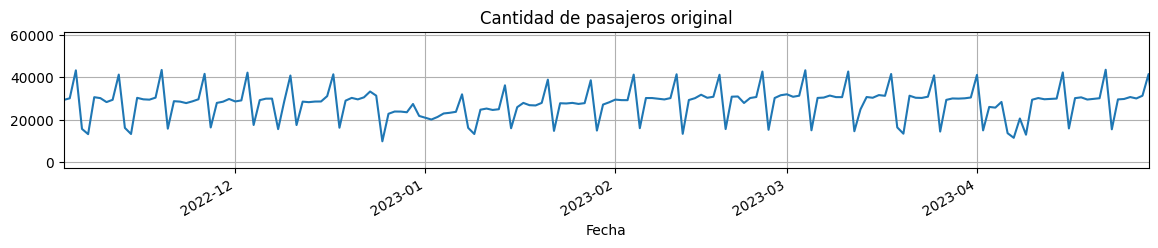

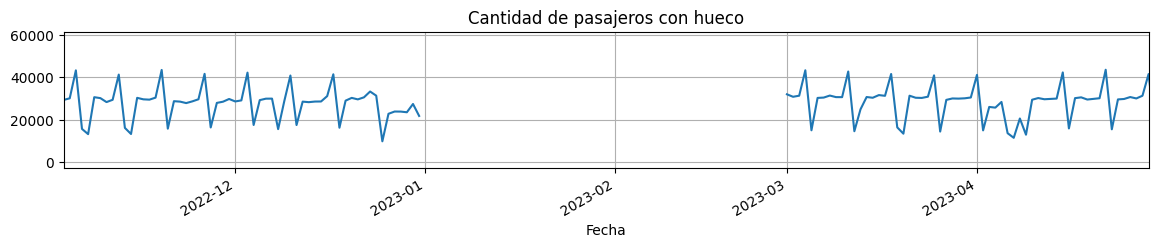

Mejor modelo encontrado con MAPE: 0.2569788777217634


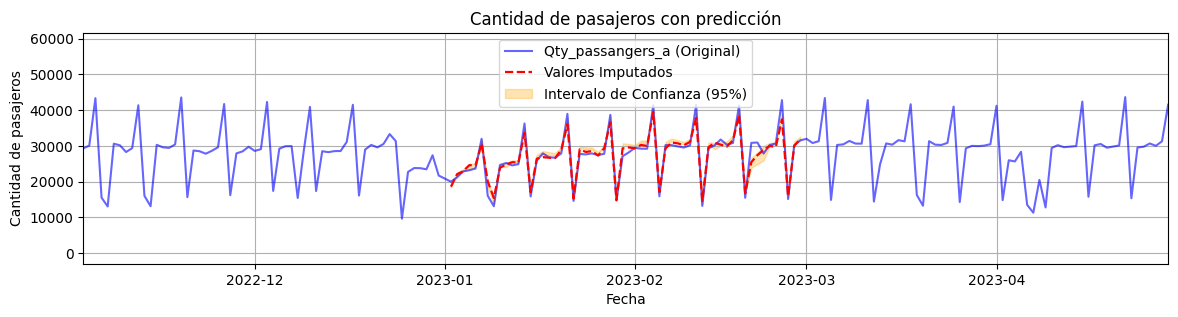

MAPE for the predicted values: 0.049144711737501276


In [150]:
target = ['Qty_passangers_a']
hora = 12

linea_data = filtrar_datos(df, hora, lineas)
df_merged = combinar_datos(linea_data, lineas)
df_merged, fechas_tramo, df_merged_copy, true_values = preparar_datos(df_merged, fechas_tramo, target)
features = df_merged.columns[~df_merged.columns.isin(target)]
df_train = df_merged[df_merged.index <= start].copy()
best_model = entrenar_modelo(df_train, features, target)
df_predicted, data_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)

# Calculate MAPE for the predicted values using true values
mape = MAPE(true_values, data_predicted)

lower_bound, upper_bound = intervalos_confianza(df_merged, fechas_tramo, features, best_model, target, output_results=False)
graficar_resultados_bootstrap(df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound)
print("MAPE for the predicted values:", mape)

# graficar_resultados(df_merged_copy, df_predicted, fechas_tramo, target)

Wilcoxon

In [151]:
def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()

    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    return df_merged, fechas_tramo, df_merged_copy

mape_by_hour = {'RANSAC': {'Limpios': {}, 'Con Outliers': {}}, 
                'RLM' : {'Limpios': {}, 'Con Outliers': {}}, 
                'RL': {'Limpios': {}, 'Con Outliers': {}}}  # Inicializa el diccionario con la clave 'RANSAC', 'RLM' y 'RL'
target = ['Qty_passangers_a']

df = leer_datos_csv(path)
for hora in df['Horas'].unique():
  linea_data = filtrar_datos(df, hora, lineas)
  df_merged = combinar_datos(linea_data, lineas)
  df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
  features = df_merged.columns[~df_merged.columns.isin(target)]
  df_train = df_merged[df_merged.index <= start].copy()
  best_model = entrenar_modelo(df_train, features, target)
  df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)
  mape_by_hour['RL']['Limpios'][hora] = MAPE(df_merged_copy.loc[fechas_tramo, target].values, df_predicted[0].loc[fechas_tramo, target].values)


Mejor modelo encontrado con MAPE: 0.044736211797907946
Mejor modelo encontrado con MAPE: 0.05381289005495432
Mejor modelo encontrado con MAPE: 0.15335806827510193
Mejor modelo encontrado con MAPE: 0.23896389345000948
Mejor modelo encontrado con MAPE: 0.2974812444162055
Mejor modelo encontrado con MAPE: 0.2036382837374137
Mejor modelo encontrado con MAPE: 0.19182896005188652
Mejor modelo encontrado con MAPE: 0.2569788777217634
Mejor modelo encontrado con MAPE: 0.2599931943766408
Mejor modelo encontrado con MAPE: 0.3098159986064986
Mejor modelo encontrado con MAPE: 0.23008171227408264
Mejor modelo encontrado con MAPE: 0.27453909288620454
Mejor modelo encontrado con MAPE: 0.07220837952110122
Mejor modelo encontrado con MAPE: 0.07116391214189108
Mejor modelo encontrado con MAPE: 0.07523020512953385
Mejor modelo encontrado con MAPE: 0.07604219810437
Mejor modelo encontrado con MAPE: 0.08252823747732822
Mejor modelo encontrado con MAPE: 0.20480849070396076


## Añadiendo valores Atipicos
---
Para la implementación de esto se hace unos cambios en algunas funciones, a continuación se vuelven a definir.

In [152]:
def filtrar_datos(df, hora, lineas):
    linea_data = {}
    for linea in lineas:
        linea_data[linea] = df[(df['Linea'] == linea) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']].copy()
        linea_data[linea].rename(columns={'Qty_passangers': f'Qty_passangers_{linea.lower()}'}, inplace=True)
        # Add outliers to the passenger series
        np.random.seed(101)
        outliers_indices = np.random.choice(linea_data[linea].index, size=int(len(linea_data[linea]) * 0.25), replace=False)
        linea_data[linea].loc[outliers_indices, f'Qty_passangers_{linea.lower()}'] *= 1.5
    return linea_data

# Implementación de una versión robusta del MAPE para evaluar los outliers
def MdAPE(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true))

def graficar_resultados_bootstrap_outliers(inliers, df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound):
    plt.figure(figsize=(14, 4))
    plt.plot(inliers.index, inliers[target], label='Original', color='black', alpha=1, lw=1.5)
    plt.plot(df_merged_copy.index, df_merged_copy[target], label='Con Outliers', color='red', alpha=0.3)
    plt.plot(df_predicted.loc[fechas_tramo, 'Fecha'], df_predicted.loc[fechas_tramo, target[0]], label='Predicciones', color='blue', lw=1.5, alpha=0.7)
    plt.fill_between(df_predicted.loc[fechas_tramo, 'Fecha'], lower_bound.squeeze(), upper_bound.squeeze(), color='grey', alpha=0.3, label='Intervalo de Confianza (95%)')
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de pasajeros')
    plt.title('Cantidad de pasajeros con predicción')
    plt.legend()
    plt.grid(True)
    plt.show()

def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros original')
    plt.show()
    true_values = df_merged.loc[fechas_tramo, target[0]].copy()  # Save true values before removing
    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros con hueco')
    plt.show()
    return df_merged, fechas_tramo, df_merged_copy, true_values

### Imputación Lineal de Pasajeros - Línea A Hora 12 en Función de las Otras Líneas entre el 2023-01-01 y el 2023-02-28 CON OUTLIERS

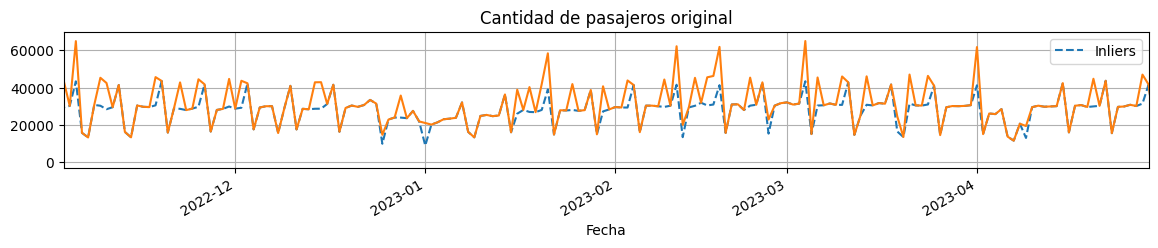

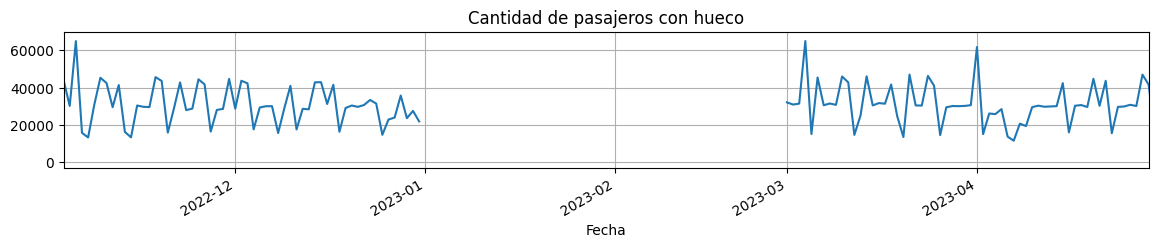

Mejor modelo encontrado con MdAPE: 0.47511818900413605


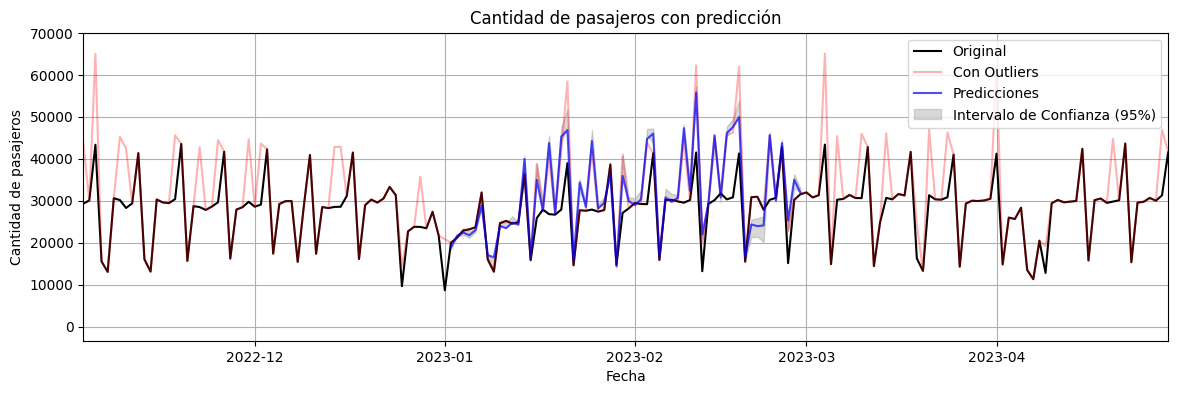

MdAPE for the predicted values: 0.05509638752042034


In [153]:
target = ['Qty_passangers_a']
hora = 12

df = leer_datos_csv(path)

# Save original data without outliers
inliers = df[(df['Linea'] == target[0][-1].upper()) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']]
inliers['Fecha'] = pd.to_datetime(inliers['Fecha'])
inliers = inliers.set_index('Fecha')
inliers = inliers.sort_index()
inliers.columns = target

# Plot inliers
inliers[target[0]].plot(figsize=(14,2), grid=True, legend=False, lw=1.5, linestyle='--')
plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
plt.legend(labels=['Inliers'])

# Process data with outliers
linea_data = filtrar_datos(df, hora, lineas)
df_merged = combinar_datos(linea_data, lineas)
df_merged, fechas_tramo, df_merged_copy, true_values = preparar_datos(df_merged, fechas_tramo, target)
features = df_merged.columns[~df_merged.columns.isin(target)]
df_train = df_merged[df_merged.index <= start].copy()
best_model = entrenar_modelo(df_train, features, target, metric='MdAPE')
df_predicted, data_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)
lower_bound, upper_bound = intervalos_confianza(df_merged, fechas_tramo, features, best_model, target, output_results=False)
graficar_resultados_bootstrap_outliers(inliers, df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound)

# Calculate MAPE for the predicted values using true values
mdape = MdAPE(true_values, data_predicted)
print("MdAPE for the predicted values:", mdape)

# graficar_resultados(inliers, df_merged_copy, df_predicted, fechas_tramo, target)

In [154]:
def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()

    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    return df_merged, fechas_tramo, df_merged_copy

target = ['Qty_passangers_a']

df = leer_datos_csv(path)
for hora in df['Horas'].unique():
  linea_data = filtrar_datos(df, hora, lineas)
  df_merged = combinar_datos(linea_data, lineas)
  df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
  features = df_merged.columns[~df_merged.columns.isin(target)]
  df_train = df_merged[df_merged.index <= start].copy()
  best_model = entrenar_modelo(df_train, features, target, metric='MdAPE')
  df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)
  mape_by_hour['RL']['Con Outliers'][hora] = MAPE(df_merged_copy.loc[fechas_tramo, target].values, df_predicted[0].loc[fechas_tramo, target].values)

Mejor modelo encontrado con MdAPE: 0.09910666891626986
Mejor modelo encontrado con MdAPE: 0.21124298136264724
Mejor modelo encontrado con MdAPE: 0.2706540652431405
Mejor modelo encontrado con MdAPE: 0.38744362310628355
Mejor modelo encontrado con MdAPE: 0.38718686992477525
Mejor modelo encontrado con MdAPE: 0.3632421453738864
Mejor modelo encontrado con MdAPE: 0.3885762929599214
Mejor modelo encontrado con MdAPE: 0.47511818900413605
Mejor modelo encontrado con MdAPE: 0.5391652822005033
Mejor modelo encontrado con MdAPE: 0.5653719054272999
Mejor modelo encontrado con MdAPE: 0.4462422978909161
Mejor modelo encontrado con MdAPE: 0.3651307576361073
Mejor modelo encontrado con MdAPE: 0.08809147899643768
Mejor modelo encontrado con MdAPE: 0.10245559505019941
Mejor modelo encontrado con MdAPE: 0.09408463051467383
Mejor modelo encontrado con MdAPE: 0.09781378682957845
Mejor modelo encontrado con MdAPE: 0.09087168675966584
Mejor modelo encontrado con MdAPE: 0.2118316130617314


Ahora realicemos el mismo analisis para los modelos robustos:

# RANSAC

In [155]:
def filtrar_datos(df, hora, lineas):
    linea_data = {}
    for linea in lineas:
        linea_data[linea] = df[(df['Linea'] == linea) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']].copy()
        linea_data[linea].rename(columns={'Qty_passangers': f'Qty_passangers_{linea.lower()}'}, inplace=True)
    return linea_data

def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros original')
    plt.show()
    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros con hueco')
    plt.show()
    return df_merged, fechas_tramo, df_merged_copy

def entrenar_modelo(df_merged, features, target, metric='MAPE'):
    best_mape = float('inf')
    best_model = None
    best_poly = None

    for max_trials in [50, 100, 150, 200, 300, 400, 500]:
        for stop_score in [inf, 0.1, 0.5]:
            for stop_probability in [0.25, 0.5, 0.99]:

                total_mape = []

                for train_index, test_index in TimeSeriesSplit(n_splits=5).split(df_merged):

                    df_train_cross_val = df_merged.iloc[train_index]
                    df_test_cross_val = df_merged.iloc[test_index]

                    ransac = RANSACRegressor(estimator=None,
                                              is_data_valid=None,
                                              is_model_valid=None,
                                              max_trials=max_trials,
                                              max_skips=inf,
                                              stop_score=stop_score,
                                              stop_probability=stop_probability,
                                              loss='squared_error',
                                              random_state=None)

                    polynomial_features = PolynomialFeatures(degree=1)

                    X_poly = polynomial_features.fit_transform(df_train_cross_val[features])

                    ransac.fit(X_poly, df_train_cross_val[target[0]])

                    X_test_poly = polynomial_features.transform(df_test_cross_val[features])

                    data_predicted = ransac.predict(X_test_poly)


                    if metric=='MAPE':
                        mape = MAPE(df_test_cross_val[target[0]], data_predicted)
                    elif metric=='MdAPE':
                        mape = MAPE(df_test_cross_val[target[0]], data_predicted)

                    total_mape.append(mape)

                avg_mape = np.mean(total_mape)

                if avg_mape < best_mape:
                    best_mape = avg_mape
                    best_model = ransac
                    best_poly = polynomial_features

    return best_model, best_poly

def predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, best_poly, target):
    X_test_poly = best_poly.transform(df_merged.loc[fechas_tramo, features].values.reshape(-1, len(features)))
    data_predicted = best_model.predict(X_test_poly)
    df_merged.loc[fechas_tramo, target[0]] = data_predicted
    df_merged['Fecha'] = df_merged.index
    return df_merged
    
def intervalos_confianza(df_merged, fechas_tramo, features, best_model, best_poly, target, output_results=False):
    n_bootstraps = 1000
    bootstrap_predictions = []

    for _ in range(n_bootstraps):
        bootstrap_sample = resample(df_merged, replace=True, n_samples=len(df_merged))
        polynomial_features = PolynomialFeatures(degree=1)
        X_poly = polynomial_features.fit_transform(bootstrap_sample[features])
        X_bootstrap = X_poly
        y_bootstrap = bootstrap_sample[target].values
        
        # Reentrenamieneto basado en el resample
        best_model.fit(X_bootstrap, y_bootstrap)
        
        # Predecir para el rango de X original
        X_test_poly = best_poly.transform(df_merged.loc[fechas_tramo, features].values.reshape(-1, len(features)))
        data_predicted = best_model.predict(X_test_poly)
        bootstrap_predictions.append(data_predicted)

    # Convertir a array
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=0)
    if output_results:
        return bootstrap_predictions, lower_bound, upper_bound
    else:
        return lower_bound, upper_bound

### Imputación Robusta de Pasajeros - Línea A Hora 12 en Función de las Otras Líneas entre el 2023-01-01 y el 2023-02-28

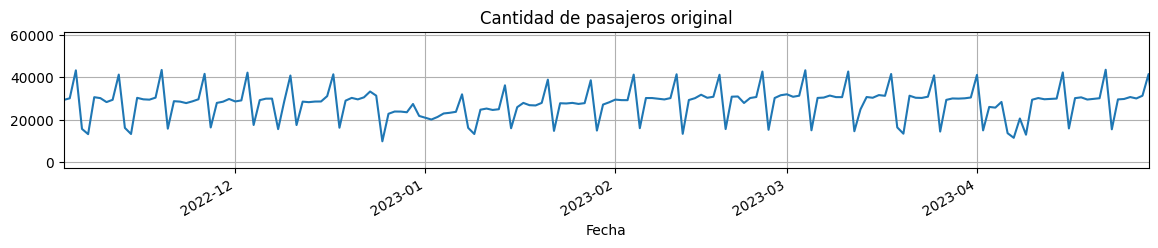

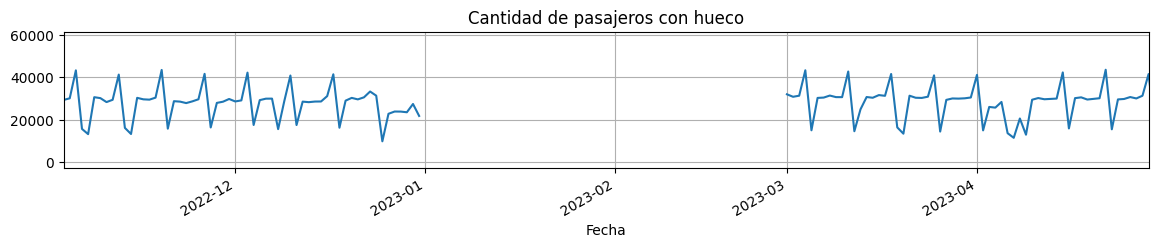

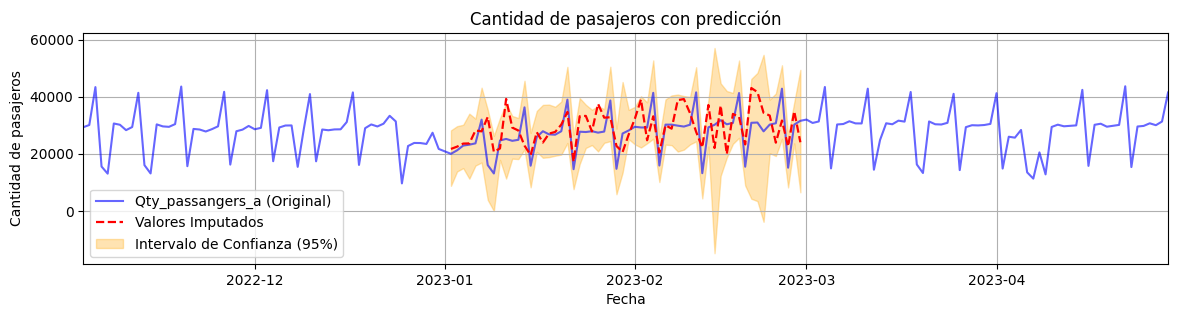

In [156]:
target = ['Qty_passangers_a']
hora = 12

df = leer_datos_csv(path)
linea_data = filtrar_datos(df, hora, lineas)
df_merged = combinar_datos(linea_data, lineas)
df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
features = df_merged.columns[~df_merged.columns.isin(target)]
df_train = df_merged[df_merged.index <= start].copy()
best_model, best_poly = entrenar_modelo(df_train, features, target)
df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, best_poly, target)
lower_bound, upper_bound = intervalos_confianza(df_merged, fechas_tramo, features, best_model, best_poly, target, output_results=False)
graficar_resultados_bootstrap(df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound)

Wilcoxon

In [157]:
def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()

    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    return df_merged, fechas_tramo, df_merged_copy

target = ['Qty_passangers_a']

df = leer_datos_csv(path)
for hora in df['Horas'].unique():
    linea_data = filtrar_datos(df, hora, lineas)
    df_merged = combinar_datos(linea_data, lineas)
    df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
    features = df_merged.columns[~df_merged.columns.isin(target)]
    df_train = df_merged[df_merged.index <= start].copy()
    best_model, best_poly = entrenar_modelo(df_train, features, target)
    df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, best_poly, target)
    mape_by_hour['RANSAC']['Limpios'][hora] = MAPE(df_merged_copy.loc[fechas_tramo, target].values, df_predicted.loc[fechas_tramo, target].values)

## Agregando Outliers:


In [158]:
def filtrar_datos(df, hora, lineas):
    linea_data = {}
    for linea in lineas:
        linea_data[linea] = df[(df['Linea'] == linea) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']].copy()
        linea_data[linea].rename(columns={'Qty_passangers': f'Qty_passangers_{linea.lower()}'}, inplace=True)
        # Agregar valores atípicos a la serie de pasajeros
        np.random.seed(101)
        outliers_indices = np.random.choice(linea_data[linea].index, size=int(len(linea_data[linea]) * 0.25), replace=False)
        linea_data[linea].loc[outliers_indices, f'Qty_passangers_{linea.lower()}'] *= 1.5
    return linea_data

def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()
    df_merged[target[0]].plot(figsize=(14,2), grid=True, label='Data con Outliers', alpha=0.6)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros original')
    plt.legend()
    plt.show()
    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros con hueco')
    plt.show()
    return df_merged, fechas_tramo, df_merged_copy

def graficar_resultados(inliers, df_merged_copy, df_predicted, fechas_tramo, target):
    plt.figure(figsize=(14, 4))
    plt.plot(inliers.index, inliers[target], label='Original', color='black', alpha=1, lw=1.5)
    plt.plot(df_merged_copy.index, df_merged_copy[target], label='Con Outliers', color='red', alpha=0.3)
    plt.plot(df_predicted.loc[fechas_tramo, 'Fecha'], df_predicted.loc[fechas_tramo, target[0]], label='Predicciones', color='blue', lw=1.5, alpha=0.7)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de pasajeros')
    plt.title('Cantidad de pasajeros con predicción')
    plt.legend()
    plt.grid(True)
    plt.show()

### Imputación Robusta de Pasajeros - Línea A Hora 12 en Función de las Otras Líneas entre el 2023-01-01 y el 2023-02-28

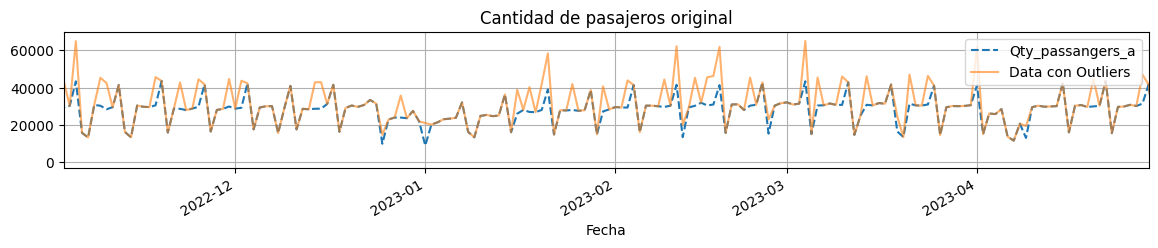

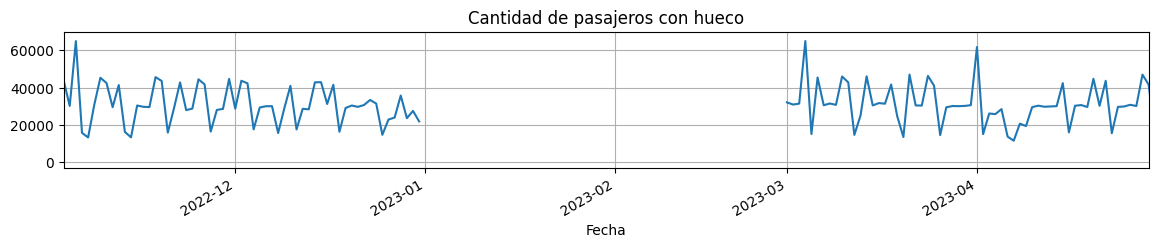

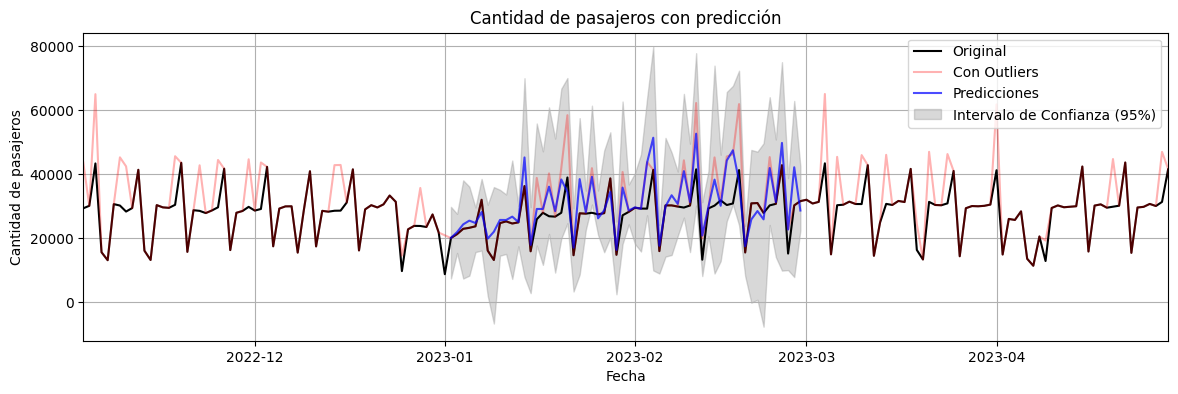

In [159]:
target = ['Qty_passangers_a']
hora = 12

df = leer_datos_csv(path)
inliers = df[(df['Linea'] == target[0][-1].upper()) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']]
inliers['Fecha'] = pd.to_datetime(inliers['Fecha'])
inliers = inliers.set_index('Fecha')
inliers = inliers.sort_index()
inliers.columns = target

inliers[target[0]].plot(figsize=(14,2), grid=True, legend=False, lw=1.5, linestyle='--')
plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
plt.legend(labels=['Inliers', 'Outliers'])

linea_data = filtrar_datos(df, hora, lineas)
df_merged = combinar_datos(linea_data, lineas)
df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
features = df_merged.columns[~df_merged.columns.isin(target)]
df_train = df_merged[df_merged.index <= start].copy()
best_model, best_poly = entrenar_modelo(df_train, features, target, metric='MdAPE')
df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, best_poly, target)
lower_bound, upper_bound = intervalos_confianza(df_merged, fechas_tramo, features, best_model, best_poly, target, output_results=False)
graficar_resultados_bootstrap_outliers(inliers, df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound)

Wilcoxon

In [160]:
def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()

    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    return df_merged, fechas_tramo, df_merged_copy

target = ['Qty_passangers_a']


df = leer_datos_csv(path)
for hora in df['Horas'].unique():
    linea_data = filtrar_datos(df, hora, lineas)
    df_merged = combinar_datos(linea_data, lineas)
    df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
    features = df_merged.columns[~df_merged.columns.isin(target)]
    df_train = df_merged[df_merged.index <= start].copy()
    best_model, best_poly = entrenar_modelo(df_train, features, target, metric='MdAPE')
    df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, best_poly, target)
    mape_by_hour['RANSAC']['Con Outliers'][hora] = MAPE(df_merged_copy.loc[fechas_tramo, target].values, df_predicted.loc[fechas_tramo, target].values)

# Robust Linear Model (RLM)

In [161]:
def leer_datos_csv(path):
    return pd.read_csv(path, usecols=['Linea', 'Horas', 'Fecha', 'Qty_passangers'], low_memory=False)

def filtrar_datos(df, hora, lineas):
    linea_data = {}
    for linea in lineas:
        linea_data[linea] = df[(df['Linea'] == linea) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']].copy()
        linea_data[linea].rename(columns={'Qty_passangers': f'Qty_passangers_{linea.lower()}'}, inplace=True)
    return linea_data

def combinar_datos(linea_data, lineas):
    df_merged = linea_data[lineas[0]]
    for linea in lineas[1:]:
        df_merged = pd.merge(df_merged, linea_data[linea], on='Fecha')
    return df_merged

def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros original')
    plt.show()
    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros con hueco')
    plt.show()
    return df_merged, fechas_tramo, df_merged_copy

def entrenar_modelo(df_merged, features, target, metric='MAPE'):
    best_mape = float('inf')
    best_model = None

    norms = [sm.robust.norms.Hampel(), sm.robust.norms.AndrewWave(),
             sm.robust.norms.HuberT(), sm.robust.norms.RamsayE(), sm.robust.norms.TrimmedMean()]

    for norm in norms:
        total_mape = []
        for train_index, test_index in TimeSeriesSplit(n_splits=5).split(df_merged):

            df_train_cross_val = df_merged.iloc[train_index]
            df_test_cross_val = df_merged.iloc[test_index]

            rlm_model = sm.RLM(df_train_cross_val[target[0]], df_train_cross_val[features], M=norm).fit()
            data_predicted = rlm_model.predict(df_test_cross_val[features])
            
            if metric=='MAPE':
                mape = MAPE(df_test_cross_val[target[0]], data_predicted)
            elif metric=='MdAPE':
                mape = MAPE(df_test_cross_val[target[0]], data_predicted)
            total_mape.append(mape)

        avg_mape = np.mean(total_mape)


        if avg_mape < best_mape:
            best_mape = avg_mape
            best_model = rlm_model
            best_M = norm

    return best_model, best_M

def predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target):
    data_predicted = best_model.predict(df_merged.loc[fechas_tramo, features].values.reshape(-1, len(features)))
    df_merged.loc[fechas_tramo, target[0]] = data_predicted
    df_merged['Fecha'] = df_merged.index
    return df_merged

def graficar_resultados(df_merged_copy, df_predicted, fechas_tramo, target):
    plt.figure(figsize=(14, 3))
    plt.plot(df_merged_copy.index, df_merged_copy[target], label=f'{target[0]} (Original)', color='blue', alpha=0.6)
    plt.plot(df_predicted.loc[fechas_tramo, 'Fecha'], df_predicted.loc[fechas_tramo, target[0]], color='red', label='Valores Imputados', lw=1.6, alpha=1, linestyle='--')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de pasajeros')
    plt.title('Cantidad de pasajeros vs Fecha')
    plt.legend()
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.grid(True)
    plt.show()


def intervalos_confianza(df_merged, fechas_tramo, features, best_M, target, output_results=False):
    n_bootstraps = 1000
    bootstrap_predictions = []

    for _ in range(n_bootstraps):
        bootstrap_sample = resample(df_merged, replace=True, n_samples=len(df_merged))
        X_bootstrap = bootstrap_sample[features]
        y_bootstrap = bootstrap_sample[target].values

        rlm_model = sm.RLM(y_bootstrap, X_bootstrap, M=best_M).fit()

        # Predecir para el rango de X original
        X_test = df_merged.loc[fechas_tramo, features].values.reshape(-1, len(features))
        data_predicted = rlm_model.predict(X_test)
        bootstrap_predictions.append(data_predicted)

    # Convertir a array
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=0)
    if output_results:
        return bootstrap_predictions, lower_bound, upper_bound
    else:
        return lower_bound, upper_bound

### Imputación Robusta de Pasajeros - Línea A Hora 12 en Función de las Otras Líneas entre el 2023-01-01 y el 2023-02-28

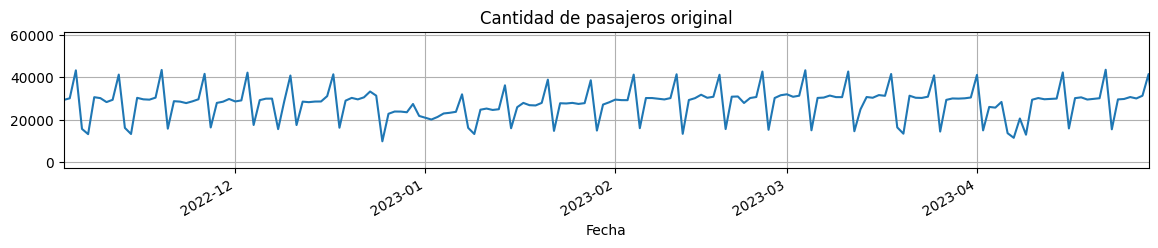

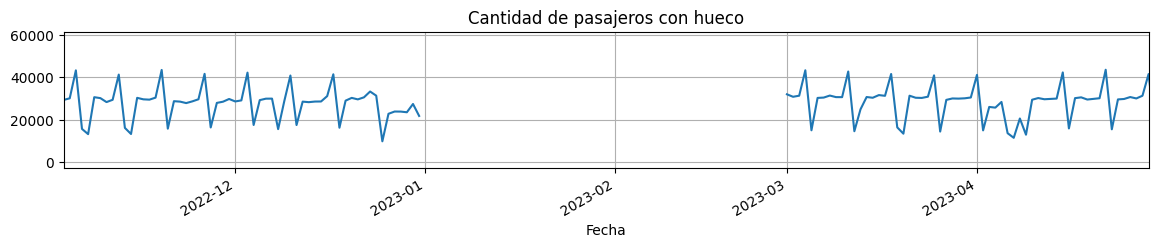

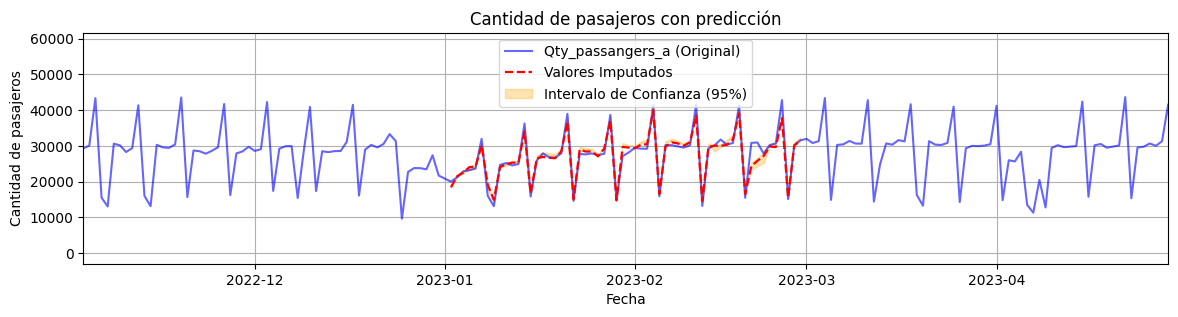

In [162]:
target = ['Qty_passangers_a']
hora = 12

df = leer_datos_csv(path)
linea_data = filtrar_datos(df, hora, lineas)
df_merged = combinar_datos(linea_data, lineas)
df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
features = df_merged.columns[~df_merged.columns.isin(target)]
df_train = df_merged[df_merged.index <= start].copy()
best_model, best_M = entrenar_modelo(df_train, features, target)
df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)
lower_bound, upper_bound = intervalos_confianza(df_merged=df_merged, fechas_tramo=fechas_tramo, features=features, best_M=best_M, target=target, output_results=False)
graficar_resultados_bootstrap(df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound)

Wilcoxon

In [163]:
def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()

    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    return df_merged, fechas_tramo, df_merged_copy


target = ['Qty_passangers_a']

df = leer_datos_csv(path)
for hora in df['Horas'].unique():
  linea_data = filtrar_datos(df, hora, lineas)
  df_merged = combinar_datos(linea_data, lineas)
  df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
  features = df_merged.columns[~df_merged.columns.isin(target)]
  df_train = df_merged[df_merged.index <= start].copy()
  best_model, best_M = entrenar_modelo(df_train, features, target)
  df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)
  mape_by_hour['RLM']['Limpios'][hora] = MAPE(df_merged_copy.loc[fechas_tramo, target].values, df_predicted.loc[fechas_tramo, target].values)

## Añadiendo valores Atipicos
---

In [164]:
def filtrar_datos(df, hora, lineas):
    linea_data = {}
    for linea in lineas:
        linea_data[linea] = df[(df['Linea'] == linea) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']].copy()
        linea_data[linea].rename(columns={'Qty_passangers': f'Qty_passangers_{linea.lower()}'}, inplace=True)
        # Agregar valores atípicos a la serie de pasajeros
        np.random.seed(101)
        outliers_indices = np.random.choice(linea_data[linea].index, size=int(len(linea_data[linea]) * 0.25), replace=False)
        linea_data[linea].loc[outliers_indices, f'Qty_passangers_{linea.lower()}'] *= 1.5
    return linea_data

def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.show()
    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.show()
    return df_merged, fechas_tramo, df_merged_copy

def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False, alpha=0.6)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros original')
    plt.show()
    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    df_merged[target[0]].plot(figsize=(14,2), grid=True, legend=False)
    plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
    plt.title('Cantidad de pasajeros con hueco')
    plt.show()
    return df_merged, fechas_tramo, df_merged_copy

### Imputación Robusta de Pasajeros - Línea A Hora 12 en Función de las Otras Líneas entre el 2023-01-01 y el 2023-02-28

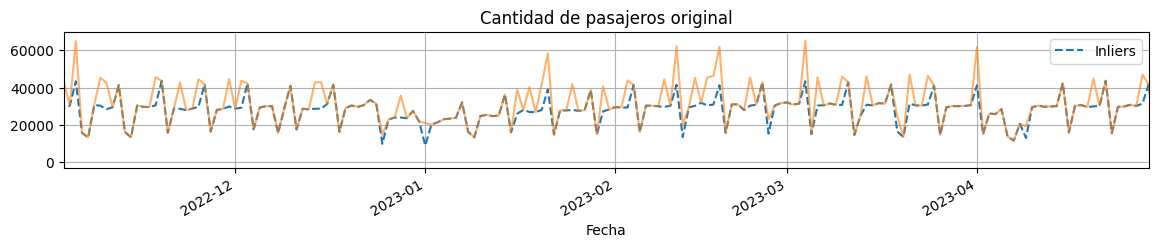

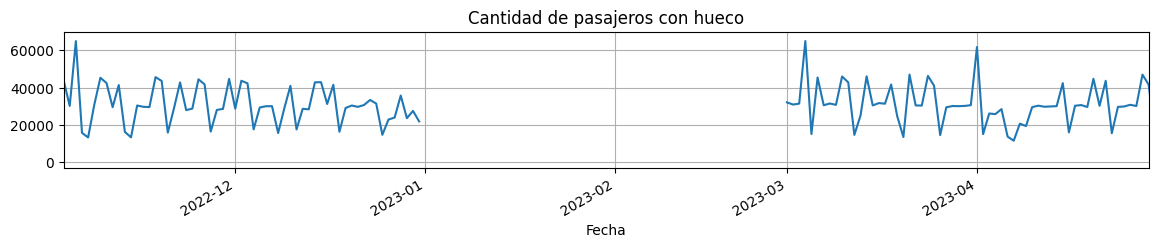

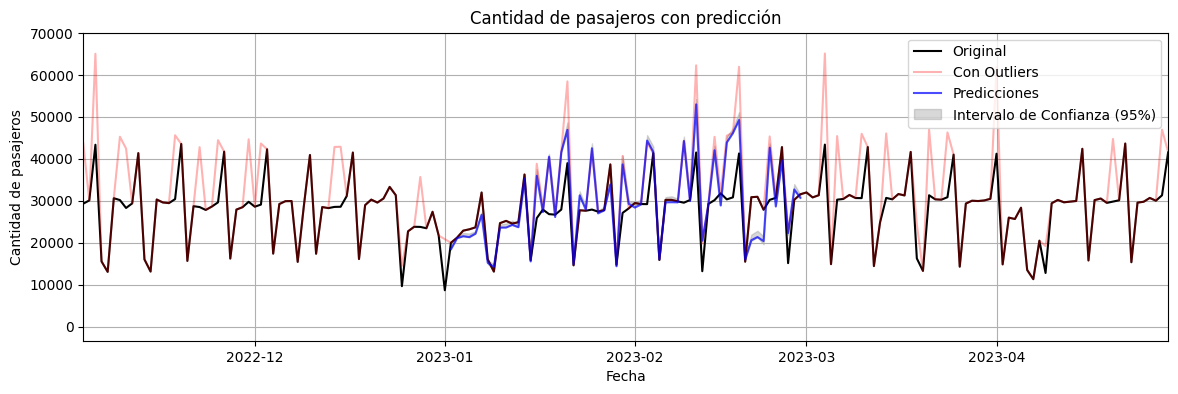

In [165]:
target = ['Qty_passangers_a']
hora = 12

df = leer_datos_csv(path)
inliers = df[(df['Linea'] == target[0][-1].upper()) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']]
inliers['Fecha'] = pd.to_datetime(inliers['Fecha'])
inliers = inliers.set_index('Fecha')
inliers = inliers.sort_index()
inliers.columns = target

inliers[target[0]].plot(figsize=(14,2), grid=True, legend=False, lw=1.5, linestyle='--')
plt.xlim([fechas_tramo[0] - pd.Timedelta(days=60), fechas_tramo[-1] + pd.Timedelta(days=60)])
plt.legend(labels=['Inliers', 'Outliers'])

linea_data = filtrar_datos(df, hora, lineas)
df_merged = combinar_datos(linea_data, lineas)
df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
features = df_merged.columns[~df_merged.columns.isin(target)]
df_train = df_merged[df_merged.index <= start].copy()
best_model, best_M = entrenar_modelo(df_train, features, target, metric='MAPE')
df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)
lower_bound, upper_bound = intervalos_confianza(df_merged=df_merged, fechas_tramo=fechas_tramo, features=features, best_M=best_M, target=target, output_results=False)
graficar_resultados_bootstrap_outliers(inliers, df_merged_copy, df_predicted, fechas_tramo, target, lower_bound, upper_bound)

Wilcoxon

In [166]:
def preparar_datos(df_merged, fechas_tramo, target):
    df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])
    df_merged = df_merged.set_index('Fecha')
    df_merged = df_merged.sort_index()
    fechas_tramo = fechas_tramo[fechas_tramo.isin(df_merged.index)]
    df_merged_copy = df_merged.copy()

    df_merged.loc[fechas_tramo, target[0]] = np.NaN
    return df_merged, fechas_tramo, df_merged_copy


target = ['Qty_passangers_a']

df = leer_datos_csv(path)
for hora in df['Horas'].unique():
  linea_data = filtrar_datos(df, hora, lineas)
  df_merged = combinar_datos(linea_data, lineas)
  df_merged, fechas_tramo, df_merged_copy = preparar_datos(df_merged, fechas_tramo, target)
  features = df_merged.columns[~df_merged.columns.isin(target)]
  df_train = df_merged[df_merged.index <= start].copy()
  best_model, best_M = entrenar_modelo(df_train, features, target, metric='MAPE')
  df_predicted = predecir_valores_faltantes(df_merged, fechas_tramo, features, best_model, target)
  mape_by_hour['RLM']['Con Outliers'][hora] = MAPE(df_merged_copy.loc[fechas_tramo, target].values, df_predicted.loc[fechas_tramo, target].values)

# Prueba de Wilcoxon


La hipotesis dice que al menos uno de los modelos robustos es mejor que el regresor lineal tradicional cuando se tiene outliers. Para esto se propone las siguientes hipotesis:

Hipotesis nula: Ninguno de los modelos robustos es mejor que el modelo lineal.

Hipotesis 1: El Modelo de RLM presenta diferencias significativas con respecto al RL. Adicional, el RLM está mas desplazado a la izquierda, en comparación que el RL

Hipotesis 2: El Modelo RANSAC presenta diferencias significativas con respecto al RL. Adicional, el RANSAC está mas desplazado a la izquierda, en comparación que el RL

Rechazo de la hipotesis nula: Al menos una de las hipotesis 1 o 2 se cumple.

## Datos Limpios

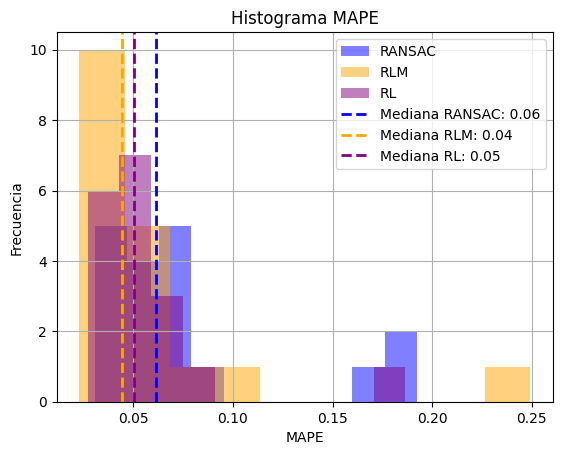

In [167]:
RANSAC = mape_by_hour['RANSAC']['Limpios'].values()
RANSAC = np.array(list(RANSAC))
RLM = mape_by_hour['RLM']['Limpios'].values()
RLM = np.array(list(RLM))
RL = mape_by_hour['RL']['Limpios'].values()
RL = np.array(list(RL))

mediana_ransac = np.median(RANSAC)
mediana_rlm = np.median(RLM)
mediana_rl = np.median(RL)

# Graficar histogramas en un solo plot
plt.hist(RANSAC, alpha=0.5, color='blue', label='RANSAC')
plt.hist(RLM, alpha=0.5, color='orange', label='RLM')
plt.hist(RL, alpha=0.5, color='purple', label='RL')
plt.axvline(mediana_ransac, color='blue', linestyle='dashed', linewidth=1, label=f'Mediana RANSAC: {mediana_ransac:.2f}',lw=2)
plt.axvline(mediana_rlm, color='orange', linestyle='dashed', linewidth=1, label=f'Mediana RLM: {mediana_rlm:.2f}', lw=2)
plt.axvline(mediana_rl, color='purple', linestyle='dashed', linewidth=1, label=f'Mediana RL: {mediana_rl:.2f}', lw=2)
plt.legend(loc='upper right')
plt.xlabel('MAPE')
plt.ylabel('Frecuencia')
plt.title('Histograma MAPE')
plt.grid(True)
plt.show()

### Conjunto de hipotesis 1:

- Hipotesis nula: El Modelo de RLM no está desplazado a la izquierda en comparación del RL.
- Rechazo de la hipotesis nula: El Modelo de RLM presenta diferencias significativas con respecto al RL. Adicional, el RLM está mas desplazado a la izquierda, en comparación que el RL

In [168]:
# Realizar la prueba de Wilcoxon

# ¿LE FUE PEOR AL RANSAC QUE AL RLM?
stat, p_value = wilcoxon(RLM, RL, alternative='less')

# Imprimir resultados
print(f'Estadístico de la prueba: {stat}')
print(f'Valor p: {p_value}')

# Nivel de significancia
alpha = 0.05

# Interpretando los resultados
if p_value < alpha:
    print("Se rechaza la hipótesis nula: la mediana del MAPE del modelo RLM es significativamente mayor que la del modelo RL.")
else:
    print("No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RLM es mayor que la del modelo RL.")

Estadístico de la prueba: 61.0
Valor p: 0.15189743041992188
No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RLM es mayor que la del modelo RL.


### Conjunto de hipotesis 2:

- Hipotesis nula: El Modelo RANSAC no está desplazado a la izquierda en comparación del RL.
- Rechazo de la hipotesis nula: El Modelo RANSAC presenta diferencias significativas con respecto al RL. Adicional, el modelo RANSAC está mas desplazado a la izquierda, en comparación que el RL

In [169]:
# Realizar la prueba de Wilcoxon

# ¿LE FUE PEOR AL RANSAC QUE AL RL?
stat, p_value = wilcoxon(RANSAC, RL, alternative='less')

# Imprimir resultados
print(f'Estadístico de la prueba: {stat}')
print(f'Valor p: {p_value}')

# Nivel de significancia
alpha = 0.05

# Interpretando los resultados
if p_value < alpha:
    print("Se rechaza la hipótesis nula: la mediana del MAPE del modelo RANSAC es significativamente mayor que la del modelo RL.")
else:
    print("No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RANSAC es mayor que la del modelo RL.")

Estadístico de la prueba: 152.0
Valor p: 0.9990348815917969
No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RANSAC es mayor que la del modelo RL.


## Con outliers

Para los conjuntos con outliers se utiliza la metrica MdAPE para evaluar los errores, ya que al tener presencia de Outliers el MAPE se puede ver afectado por errores muy grandes

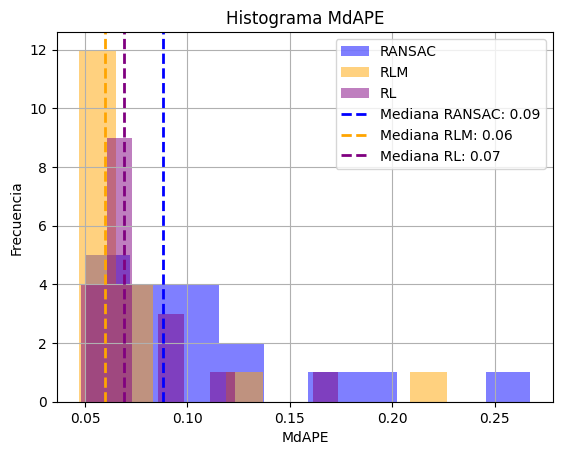

In [170]:
RANSAC = mape_by_hour['RANSAC']['Con Outliers'].values()
RANSAC = np.array(list(RANSAC))
RLM = mape_by_hour['RLM']['Con Outliers'].values()
RLM = np.array(list(RLM))
RL = mape_by_hour['RL']['Con Outliers'].values()
RL = np.array(list(RL))

mediana_ransac = np.median(RANSAC)
mediana_rlm = np.median(RLM)
mediana_rl = np.median(RL)

# Graficar histogramas en un solo plot
plt.hist(RANSAC, alpha=0.5, color='blue', label='RANSAC')
plt.hist(RLM, alpha=0.5, color='orange', label='RLM')
plt.hist(RL, alpha=0.5, color='purple', label='RL')
plt.axvline(mediana_ransac, color='blue', linestyle='dashed', linewidth=1, label=f'Mediana RANSAC: {mediana_ransac:.2f}',lw=2)
plt.axvline(mediana_rlm, color='orange', linestyle='dashed', linewidth=1, label=f'Mediana RLM: {mediana_rlm:.2f}', lw=2)
plt.axvline(mediana_rl, color='purple', linestyle='dashed', linewidth=1, label=f'Mediana RL: {mediana_rl:.2f}', lw=2)
plt.legend(loc='upper right')
plt.xlabel('MdAPE')
plt.ylabel('Frecuencia')
plt.title('Histograma MdAPE')
plt.grid(True)
plt.show()

### Conjunto de hipotesis 1:

- Hipotesis nula: El Modelo de RLM no está desplazado a la izquierda en comparación del RL.
- Rechazo de la hipotesis nula: El Modelo de RLM presenta diferencias significativas con respecto al RL. Adicional, el RLM está mas desplazado a la izquierda, en comparación que el RL

In [171]:
# Realizar la prueba de Wilcoxon

stat, p_value = wilcoxon(RLM, RL, alternative='less')

# Imprimir resultados
print(f'Estadístico de la prueba: {stat}')
print(f'Valor p: {p_value}')

# Nivel de significancia
alpha = 0.05

# Interpretando los resultados
if p_value < alpha:
    print("Se rechaza la hipótesis nula: la mediana del MAPE del modelo RLM es significativamente mayor que la del modelo RL.")
else:
    print("No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RLM es mayor que la del modelo RL.")

Estadístico de la prueba: 64.0
Valor p: 0.18460845947265625
No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RLM es mayor que la del modelo RL.


### Conjunto de hipotesis 2:

- Hipotesis nula: El Modelo RANSAC no está desplazado a la izquierda en comparación del RL.
- Rechazo de la hipotesis nula: El Modelo RANSAC presenta diferencias significativas con respecto al RL. Adicional, el modelo RANSAC está mas desplazado a la izquierda, en comparación que el RL

In [172]:
# Realizar la prueba de Wilcoxon

stat, p_value = wilcoxon(RANSAC, RL, alternative='less')

# Imprimir resultados
print(f'Estadístico de la prueba: {stat}')
print(f'Valor p: {p_value}')

# Nivel de significancia
alpha = 0.05

# Interpretando los resultados
if p_value < alpha:
    print("Se rechaza la hipótesis nula: la mediana del MAPE del modelo RANSAC es significativamente mayor que la del modelo RL.")
else:
    print("No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RANSAC es mayor que la del modelo RL.")

Estadístico de la prueba: 139.0
Valor p: 0.992034912109375
No se rechaza la hipótesis nula: no hay evidencia suficiente para afirmar que la mediana del MAPE del modelo RANSAC es mayor que la del modelo RL.


# Correlaciones Robustas

In [173]:
def filtrar_datos(df, hora, lineas):
    linea_data = {}
    for linea in lineas:
        linea_data[linea] = df[(df['Linea'] == linea) & (df['Horas'] == hora)][['Fecha', 'Qty_passangers']].copy()
        linea_data[linea].rename(columns={'Qty_passangers': f'Qty_passangers_{linea.lower()}'}, inplace=True)
    return linea_data

target = ['Qty_passangers_a']
hora = 12

df = leer_datos_csv(path)
linea_data = filtrar_datos(df, hora, lineas)
df_merged = combinar_datos(linea_data, lineas)

Encontramos la correlación de Pearson para cada linea con cada linea

In [174]:
pearson = df_merged.drop(['Fecha'], axis=1).corr(method='pearson')
pearson

,Qty_passangers_a,Qty_passangers_b,Qty_passangers_1,Qty_passangers_2,Qty_passangers_h,Qty_passangers_j,Qty_passangers_k,Qty_passangers_m,Qty_passangers_o,Qty_passangers_t-a
Qty_passangers_a,1.000000,0.962023,0.935872,0.867947,0.709027,0.840426,0.752637,0.774996,0.787466,0.856844
Qty_passangers_b,0.962023,1.000000,0.922304,0.877566,0.757014,0.876182,0.793128,0.825270,0.849481,0.900886
Qty_passangers_1,0.935872,0.922304,1.000000,0.919434,0.727735,0.812479,0.738146,0.752003,0.862267,0.889073
Qty_passangers_2,0.867947,0.877566,0.919434,1.000000,0.747876,0.807118,0.746307,0.784422,0.842849,0.891313
Qty_passangers_h,0.709027,0.757014,0.727735,0.747876,1.000000,0.791338,0.746624,0.790616,0.693510,0.822697
Qty_passangers_j,0.840426,0.876182,0.812479,0.807118,0.791338,1.000000,0.866159,0.811767,0.754725,0.835873
Qty_passangers_k,0.752637,0.793128,0.738146,0.746307,0.746624,0.866159,1.000000,0.737495,0.697964,0.779595
Qty_passangers_m,0.774996,0.825270,0.752003,0.784422,0.790616,0.811767,0.737495,1.000000,0.738704,0.884201
Qty_passangers_o,0.787466,0.849481,0.862267,0.842849,0.693510,0.754725,0.697964,0.738704,1.000000,0.900450
Qty_passangers_t-a,0.856844,0.900886,0.889073,0.891313,0.822697,0.835873,0.779595,0.884201,0.900450,1.000000


Ahora la correlación de Kendall de cada linea con cada linea

In [175]:
kendall = df_merged.drop(['Fecha'], axis=1).corr(method='kendall')
kendall

,Qty_passangers_a,Qty_passangers_b,Qty_passangers_1,Qty_passangers_2,Qty_passangers_h,Qty_passangers_j,Qty_passangers_k,Qty_passangers_m,Qty_passangers_o,Qty_passangers_t-a
Qty_passangers_a,1.000000,0.813095,0.812059,0.723282,0.519040,0.650010,0.553963,0.602769,0.656123,0.718452
Qty_passangers_b,0.813095,1.000000,0.806968,0.744938,0.566804,0.696221,0.605269,0.656745,0.729294,0.782206
Qty_passangers_1,0.812059,0.806968,1.000000,0.764102,0.536537,0.646110,0.553060,0.603183,0.710876,0.756125
Qty_passangers_2,0.723282,0.744938,0.764102,1.000000,0.555718,0.654764,0.570256,0.637820,0.698148,0.752629
Qty_passangers_h,0.519040,0.566804,0.536537,0.555718,1.000000,0.587320,0.540755,0.587847,0.530677,0.608889
Qty_passangers_j,0.650010,0.696221,0.646110,0.654764,0.587320,1.000000,0.643102,0.643693,0.620886,0.664034
Qty_passangers_k,0.553963,0.605269,0.553060,0.570256,0.540755,0.643102,1.000000,0.552101,0.583899,0.600667
Qty_passangers_m,0.602769,0.656745,0.603183,0.637820,0.587847,0.643693,0.552101,1.000000,0.594709,0.708138
Qty_passangers_o,0.656123,0.729294,0.710876,0.698148,0.530677,0.620886,0.583899,0.594709,1.000000,0.781655
Qty_passangers_t-a,0.718452,0.782206,0.756125,0.752629,0.608889,0.664034,0.600667,0.708138,0.781655,1.000000


Y tambien la correlación de Pearson de cada linea con cada linea:

In [176]:
spearman = df_merged.drop(['Fecha'], axis=1).corr(method='spearman')
spearman

,Qty_passangers_a,Qty_passangers_b,Qty_passangers_1,Qty_passangers_2,Qty_passangers_h,Qty_passangers_j,Qty_passangers_k,Qty_passangers_m,Qty_passangers_o,Qty_passangers_t-a
Qty_passangers_a,1.000000,0.945157,0.934813,0.869546,0.716010,0.834997,0.746460,0.795278,0.840440,0.878876
Qty_passangers_b,0.945157,1.000000,0.938331,0.893314,0.760466,0.865288,0.785226,0.842903,0.898154,0.925764
Qty_passangers_1,0.934813,0.938331,1.000000,0.911668,0.732408,0.831068,0.752404,0.792300,0.888220,0.906518
Qty_passangers_2,0.869546,0.893314,0.911668,1.000000,0.743805,0.835739,0.758473,0.820833,0.869713,0.901103
Qty_passangers_h,0.716010,0.760466,0.732408,0.743805,1.000000,0.774844,0.726808,0.779009,0.726785,0.803062
Qty_passangers_j,0.834997,0.865288,0.831068,0.835739,0.774844,1.000000,0.818297,0.825664,0.814109,0.846145
Qty_passangers_k,0.746460,0.785226,0.752404,0.758473,0.726808,0.818297,1.000000,0.735855,0.770445,0.784554
Qty_passangers_m,0.795278,0.842903,0.792300,0.820833,0.779009,0.825664,0.735855,1.000000,0.791006,0.885075
Qty_passangers_o,0.840440,0.898154,0.888220,0.869713,0.726785,0.814109,0.770445,0.791006,1.000000,0.926772
Qty_passangers_t-a,0.878876,0.925764,0.906518,0.901103,0.803062,0.846145,0.784554,0.885075,0.926772,1.000000


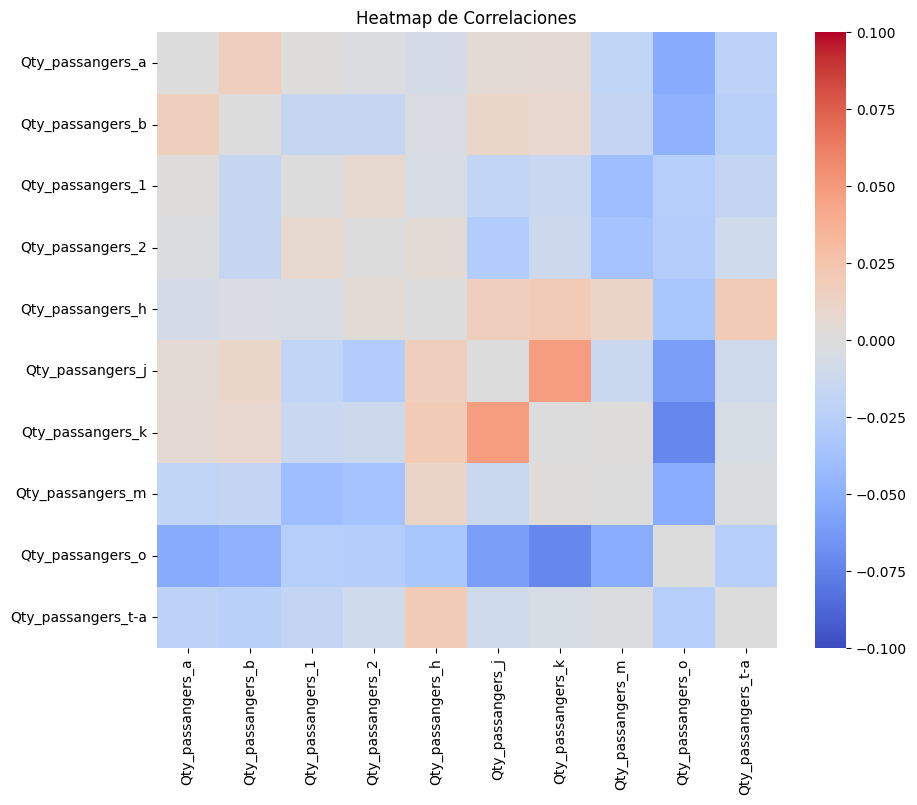

In [177]:
# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson - spearman, cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.title('Heatmap de Correlaciones')
plt.show()